# Erebus Horizontal to Vertical Power Ratio Plot

In [1]:
import pandas as pd
import numpy as np
import datetime
import scipy
import matplotlib.pyplot as plt
import matplotlib
import obspy
import obspy.clients.fdsn
from matplotlib.transforms import ScaledTranslation
import matplotlib

matplotlib.rc('pdf', fonttype=42)

plt.style.use("/home/mchristo/proj/libmsc/style/msc.mplstyle")

## Load power ratio

In [2]:
nkb = pd.read_csv("./data/hvpr/ER_NKB_hvpr.txt", index_col="index")
nkb["time"] = pd.to_datetime(nkb["time"])

e1s = pd.read_csv("./data/hvpr/ER_E1S_hvpr.txt", index_col="index")
e1s["time"] = pd.to_datetime(e1s["time"])

def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

# Filter out extreme differences
e1s = e1s[e1s["n"]/e1s["e"] < 1e2]
e1s = e1s[e1s["n"]/e1s["e"] > 1e-2]

nkb = nkb[nkb["n"]/nkb["e"] < 1e2]
nkb = nkb[nkb["n"]/nkb["e"] > 1e-2]

## MODIS

In [3]:
modis = np.genfromtxt("./data/modis_plot_data.txt", dtype=None, skip_header=1, names = ['time','cnt','radiance', 'power'])
t_modis = [year_fraction(datetime.datetime.fromtimestamp(t)) for t in modis['time']]

## Load explosions

In [4]:
ex_data = scipy.io.loadmat("./data/Eruptions_max_times.mat")

del ex_data["__header__"]
del ex_data["__version__"]
del ex_data["__globals__"]

# Undo some weird structure from mat file reading
ex_data["eruption_time"] = [str(time[0]) for time in ex_data["eruption_time"][0]]
ex_data["mx"] = ex_data["mx"][0]

df = pd.DataFrame(ex_data)

# Convert times to datetime objects
df["eruption_time"] = pd.to_datetime(df["eruption_time"], format="%Y %j %H %M %S")
df["cnt"]           = 1
df                  = df.drop(columns=["mx"])
df_weeks            = df.groupby(pd.Grouper(key="eruption_time", freq="7D")).sum().reset_index()
t2                   = [year_fraction(x) for x in df_weeks["eruption_time"]]

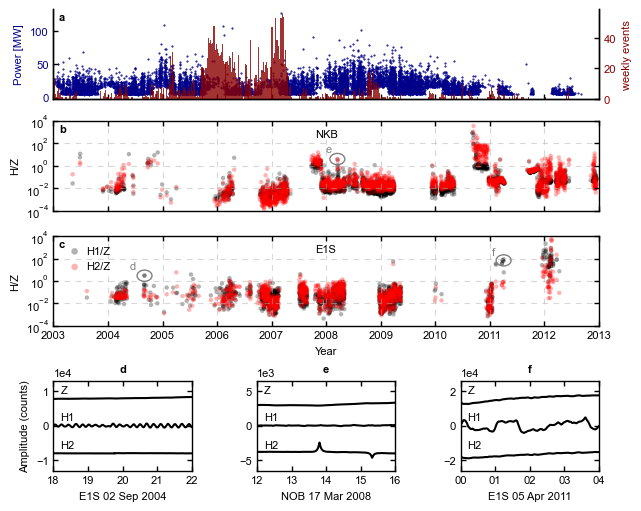

In [8]:
fig = plt.figure(figsize=(6.3, 5), constrained_layout=True)
gs = matplotlib.gridspec.GridSpec(4, 3, figure=fig)

# MODIS + Explosion histogram
ax0 = fig.add_subplot(gs[0,:])

col = "darkblue"
ax0.plot(t_modis, modis['power'], '.', color=col,  markersize=1, zorder=1)
ax0.set_ylabel('Power [MW]', color=col, fontsize=8)
ax0.tick_params(axis='y', labelcolor=col)

col = "darkred"

ax0.spines['top'].set_visible(False)
ax0.grid(False)
ax0.xaxis.tick_bottom()
ax0_twin = ax0.twinx()
ax0_twin.bar(t2, df_weeks['cnt'], color=col, width=0.02, alpha=0.8, zorder=2)
ax0_twin.set_ylabel('weekly events', color=col, fontsize=8)  # we already handled the x-label with ax1
ax0_twin.grid(False)
ax0_twin.tick_params(axis='y', labelcolor=col)
ax0_twin.spines['top'].set_visible(False)
ax0.set_xlim(2003, 2013)
ax0.set_xticks(np.arange(2003, 2013))
ax0.set_xticklabels([])
ax0.tick_params(axis='both', which='major', labelsize=8)

alabel = ax0.annotate(
    "a",
    (.01,.875),
    xycoords="axes fraction",
    fontsize=8,
    fontweight="bold",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)

# For plotting HVPR
alpha = .3
csize=10
x0 = datetime.datetime.strptime("2003", "%Y")
x1 = datetime.datetime.strptime("2013", "%Y")

# NKB HVPR
ax1 = fig.add_subplot(gs[1,:])
ax1.set_yscale("log")
ax1.scatter(nkb["time"], nkb["n"]/nkb["z"], label="H1/Z", s=csize, color="black", alpha=alpha, edgecolor="none")
ax1.scatter(nkb["time"], nkb["e"]/nkb["z"], label="H2/Z", s=csize, color="red", alpha=alpha, edgecolor="none")
ax1.set_xlim(x0, x1)
ax1.set_xticklabels([])
ax1.set_ylabel("H/Z", fontsize=8)
#ax1.legend(loc="upper left", frameon=False, fontsize=8, markerscale=1.5, handletextpad=0.0)
ax1.set_ylim(1e-4, 1e4)
ax1.annotate(
    "NKB", 
    (0.479, 0.82), 
    xycoords="axes fraction", 
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)
ax1.tick_params(axis='both', which='major', labelsize=8)

blabel = ax1.annotate(
    "b",
    (.01,.875),
    xycoords="axes fraction",
    fontsize=8,
    fontweight="bold",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)

# E1S HVPR
ax2 = fig.add_subplot(gs[2,:])
ax2.set_yscale("log")
ax2.scatter(e1s["time"], e1s["n"]/e1s["z"], label="H1/Z", s=csize, color="black", alpha=alpha, edgecolor="none")
ax2.scatter(e1s["time"], e1s["e"]/e1s["z"], label="H2/Z", s=csize, color="red", alpha=alpha, edgecolor="none")
ax2.set_xlabel("Year", fontsize=8)
ax2.set_xlim(x0, x1)
ax2.set_ylabel("H/Z", fontsize=8)
ax2.legend(loc="upper left", frameon=False, fontsize=8, markerscale=1.5, handletextpad=0.0)
ax2.set_ylim(1e-4, 1e4)
ax2.annotate(
    "E1S", 
    (0.479, 0.82), 
    xycoords="axes fraction", 
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)
ax2.tick_params(axis='both', which='major', labelsize=8)

clabel = ax2.annotate(
    "c",
    (.01,.875),
    xycoords="axes fraction",
    fontsize=8,
    fontweight="bold",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)

# Add circles with annotations

center = [obspy.UTCDateTime("2004-09-02").matplotlib_date, 3]
ell_offset = ScaledTranslation(center[0], center[1], ax2.transScale)
ell_tform = ell_offset + ax2.transLimits + ax2.transAxes
ex = 100
ey = 1
ax2.add_patch(matplotlib.patches.Ellipse(xy=(0, 0), width=ex, height=ey, color="grey", fill=False, lw=1, zorder=5, transform=ell_tform))
dlabel = ax2.annotate("d", (center[0]-100, center[1]+8), fontsize=8, color="grey")

center = [obspy.UTCDateTime("2011-04-05").matplotlib_date, 0.7e2]
ell_offset = ScaledTranslation(center[0], center[1], ax2.transScale)
ell_tform = ell_offset + ax2.transLimits + ax2.transAxes
ex = 100
ey = 1
ax2.add_patch(matplotlib.patches.Ellipse(xy=(0, 0), width=ex, height=ey, color="grey", fill=False, lw=1, zorder=5, transform=ell_tform))
flabel = ax2.annotate("f", (center[0]-80, center[1]+120), fontsize=8, color="grey")

center = [obspy.UTCDateTime("2008-03-17").matplotlib_date, 4]
ell_offset = ScaledTranslation(center[0], center[1], ax1.transScale)
ell_tform = ell_offset + ax1.transLimits + ax1.transAxes
ex = 100
ey = 1
ax1.add_patch(matplotlib.patches.Ellipse(xy=(0, 0), width=ex, height=ey, color="grey", fill=False, lw=1, zorder=5, transform=ell_tform))
elabel = ax1.annotate("e", (center[0]-80, center[1]+12), fontsize=8, color="grey")


# Timeseries callouts (d)
ax3 = fig.add_subplot(gs[3,0])
st = obspy.read("./data/erebus/E1S-2004-09-02.zip")
t0 = obspy.UTCDateTime("2004-09-02T18:00:00")
t1 = obspy.UTCDateTime("2004-09-02T22:00:00")

st.detrend(type="demean").filter(type="lowpass", freq=1e-3, corners=1, zerophase=True)
    
ofst = 8e3

for tr in st.select(component="Z"):
    ax3.plot(tr.times("matplotlib"), tr.data + ofst, "k-")

for tr in st.select(component="1"):
    ax3.plot(tr.times("matplotlib"), tr.data, "k-")
            
for tr in st.select(component="2"):
    ax3.plot(tr.times("matplotlib"), tr.data - ofst, "k-")

ax3.set_ylim(-13e3, 13e3)
ax3.set_xlim(t0.matplotlib_date, t1.matplotlib_date)
ax3.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(byminute=[0]))
ax3.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H"))

ax3.annotate("Z", xy=(t0.matplotlib_date+(.2/24), ofst + 1.5e3), fontsize=8)
ax3.annotate("H1", xy=(t0.matplotlib_date+(.2/24), 1.5e3), fontsize=8)
ax3.annotate("H2", xy=(t0.matplotlib_date+(.2/24), -ofst + 1.5e3), fontsize=8)

ax3.set_xlabel("E1S 02 Sep 2004", fontsize=8)

ax3.tick_params(axis='both', which='major', labelsize=8)
ax3.set_title("d", fontsize=8, fontweight="bold")
ax3.set_ylabel("Amplitude (counts)", fontsize=8)
ax3.axes.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) 
ax3.grid(False)


# Timeseries callouts (e)
ax4 = fig.add_subplot(gs[3,1])
st = obspy.read("./data/erebus/NKB-2008-03-17.zip")
t0 = obspy.UTCDateTime("2008-03-17T12:00:00")
t1 = obspy.UTCDateTime("2008-03-17T16:00:00")
st.detrend(type="linear").filter(type="lowpass", freq=1e-3, corners=1, zerophase=True).trim(starttime=t0, endtime=t1)

tz = st.select(component="Z")[0].times("matplotlib")
th1 = st.select(component="1")[0].times("matplotlib")
th2 = st.select(component="2")[0].times("matplotlib")

z = st.select(component="Z")[0].data
h1 = st.select(component="1")[0].data
h2 = st.select(component="2")[0].data

ofst = 8e3/2
ax4.plot(tz, z + ofst, "k-")
ax4.plot(th1, h1, "k-")
ax4.plot(th2, h2 - ofst, "k-")
ax4.set_ylim(-13e3/2, 13e3/2)
ax4.set_xlim(tz[0], tz[-1])
ax4.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(byminute=[0]))
ax4.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H"))

ax4.annotate("Z", xy=(t0.matplotlib_date+(.2/24), ofst + 1.5e3/2), fontsize=8)
ax4.annotate("H1", xy=(t0.matplotlib_date+(.2/24), 1.5e3/2), fontsize=8)
ax4.annotate("H2", xy=(t0.matplotlib_date+(.2/24), -ofst + 1.5e3/2), fontsize=8)

ax4.set_xlabel("NOB 17 Mar 2008", fontsize=8)
ax4.tick_params(axis='both', which='major', labelsize=8)
ax4.axes.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) 
ax4.set_title("e", fontsize=8, fontweight="bold")
ax4.grid(False)


# Timeseries callouts (f)
ax5 = fig.add_subplot(gs[3,2])
st = obspy.read("./data/erebus/E1S-2011-04-05.zip")
t0 = obspy.UTCDateTime("2011-04-05T00:00:00")
t1 = obspy.UTCDateTime("2011-04-05T04:00:00")
st.detrend(type="linear").filter(type="lowpass", freq=1e-3, corners=1, zerophase=True).trim(starttime=t0, endtime=t1)

t = st.select(component="Z")[0].times("matplotlib")
z = st.select(component="Z")[0].data
h1 = st.select(component="1")[0].data
h2 = st.select(component="2")[0].data

ofst = 8e3*2
ax5.plot(t, z + ofst, "k-")
ax5.plot(t, h1, "k-")
ax5.plot(t, h2 - ofst, "k-")
ax5.set_ylim(-13e3*2, 13e3*2)
ax5.set_xlim(t[0], t[-1])
ax5.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(byminute=[0]))
ax5.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H"))

ax5.annotate("Z", xy=(t0.matplotlib_date+(.2/24), ofst + 1.5e3*2), fontsize=8)
ax5.annotate("H1", xy=(t0.matplotlib_date+(.2/24), 1.5e3*2), fontsize=8)
ax5.annotate("H2", xy=(t0.matplotlib_date+(.2/24), -ofst + 1.5e3*2), fontsize=8)

ax5.set_xlabel("E1S 05 Apr 2011", fontsize=8)
ax4.tick_params(axis='both', which='major', labelsize=8)
ax5.axes.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) 
ax5.set_title("f", fontsize=8, fontweight="bold")
ax5.grid(False)

fig.savefig("figs/erebus_hvpr.pdf", bbox_inches="tight")

# Changes for MS thesis presentation 

#alabel.remove()
#blabel.remove()
#clabel.remove()
#dlabel.remove()
#elabel.remove()
#flabel.remove()

#center = [obspy.UTCDateTime("2004-09-02").matplotlib_date, 3]
#ax2.annotate("a", (center[0]-100, center[1]+8), fontsize=8, color="grey")
#center = [obspy.UTCDateTime("2008-03-17").matplotlib_date, 4]
#ax1.annotate("b", (center[0]-80, center[1]+12), fontsize=8, color="grey")
#center = [obspy.UTCDateTime("2011-04-05").matplotlib_date, 0.7e2]
#ax2.annotate("c", (center[0]-80, center[1]+120), fontsize=8, color="grey")

#ax3.set_title("a", fontsize=8)
#ax4.set_title("b", fontsize=8)
#ax5.set_title("c", fontsize=8)

#fig.savefig("figs/png/erebus_hvpr.png", dpi=300, bbox_inches="tight")